In [1]:
import numpy as np
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import Conv3D, Activation, Concatenate
from keras.optimizers import Adam
from functools import partial
import tensorflow as tf
import os
patch_size =64
K.set_image_data_format("channels_last")
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops

In [3]:
from keras.layers.advanced_activations import LeakyReLU
class LeakyReLU(LeakyReLU):
    def __init__(self, **kwargs):
        self.__name__ = "LeakyReLU"
        super(LeakyReLU, self).__init__(**kwargs)  


def mean_sq_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def tf_psnrmain(y_true, y_pred):
    return tf_psnr(y_true, y_pred, max_val=1.0, name=None)
def tf_psnr(a, b, max_val, name=None):
    """Returns the Peak Signal-to-Noise Ratio between a and b.
    This is intended to be used on signals (or images). Produces a PSNR value for
    each image in batch.
    The last three dimensions of input are expected to be [height, width, depth].
    Example:
    ```python
    # Read images from file.
    im1 = tf.decode_png('path/to/im1.png')
    im2 = tf.decode_png('path/to/im2.png')
    # Compute PSNR over tf.uint8 Tensors.
    psnr1 = tf.image.psnr(im1, im2, max_val=255)
    # Compute PSNR over tf.float32 Tensors.
    im1 = tf.image.convert_image_dtype(im1, tf.float32)
    im2 = tf.image.convert_image_dtype(im2, tf.float32)
    psnr2 = tf.image.psnr(im1, im2, max_val=1.0)
    # psnr1 and psnr2 both have type tf.float32 and are almost equal.
    ```
    Arguments:
    a: First set of images.
    b: Second set of images.
    max_val: The dynamic range of the images (i.e., the difference between the
    maximum the and minimum allowed values).
    name: Namespace to embed the computation in.
    Returns:
    The scalar PSNR between a and b. The returned tensor has type `tf.float32`
    and shape [batch_size, 1].
    """
    with ops.name_scope(name, 'PSNR', [a, b]):
    # Need to convert the images to float32.  Scale max_val accordingly so that
    # PSNR is computed correctly.
        max_val = math_ops.cast(max_val, a.dtype)
#         max_val = convert_image_dtype(max_val, dtypes.float32)
#         a = convert_image_dtype(a, dtypes.float32)
#         b = convert_image_dtype(b, dtypes.float32)
        mse = math_ops.reduce_mean(math_ops.squared_difference(a, b), [-4, -3, -2])
        psnr_val = math_ops.subtract(
        20 * math_ops.log(max_val) / math_ops.log(10.0),
        np.float64(10 / np.log(10)) * math_ops.log(mse),
        name='psnr')

#         _, _, checks = _verify_compatible_image_shapes(a, b)
#         with ops.control_dependencies(checks):
        return array_ops.identity(psnr_val)
        
def DenseNet(patch_size=64, growth_rate=24):
    n_channels=growth_rate
    input_shape=(patch_size, patch_size, patch_size, 1)

    inputs = Input(input_shape)
    #Initial Convolution Layer
    x = Conv3D(filters=2*growth_rate,  kernel_size=(3, 3, 3), padding='same', activation = LeakyReLU(alpha=0.1))(inputs)

    no_layers = 4
    for i in range(no_layers):
        x_list = [x]
        cb = Conv3D(filters=2*growth_rate,  kernel_size=(3, 3, 3), padding='same', activation = LeakyReLU(alpha=0.1))(x)
        x_list.append(cb)
        x = Concatenate(axis=-1)(x_list)
        
        n_channels += growth_rate
        # for transititon layer
        x = Conv3D( n_channels,kernel_size=(1, 1, 1), padding='same', activation = LeakyReLU(alpha=0.1)) (x)
        

    x = Conv3D( 1,kernel_size=(3, 3, 3), padding='same') (x)
    model = Model(inputs=inputs, outputs=x)

    adamOpt = Adam(lr=0.00001)
    model.compile(loss='mean_squared_error', optimizer=adamOpt,metrics=[mean_sq_error, tf_psnrmain ])
    model.summary(line_length=110)
    return model

In [4]:
model = DenseNet(patch_size=64, growth_rate=24)

d:\miniconda\envs\keraspy3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
input_1 (InputLayer)                (None, 64, 64, 64, 1)   0                                                 
______________________________________________________________________________________________________________
conv3d_1 (Conv3D)                   (None, 64, 64, 64, 48)  1344         input_1[0][0]                        
______________________________________________________________________________________________________________
conv3d_2 (Conv3D)                   (None, 64, 64, 64, 48)  62256        conv3d_1[0][0]                       
______________________________________________________________________________________________________________
concatenate_1 (Concatenate)         (None, 64, 64, 64, 96)  0            conv3d_1[0][0]                       
 

<h1> Prediction for Patches

In [5]:
valImgLR = np.load('patches3D/patchesStandardized/patchesvalImgLR.npy')

In [6]:
checkpoint_filename = 'model-019.h5'
checkpoint_filepath = 'outputServer/' + checkpoint_filename
model.load_weights(checkpoint_filepath, reshape=True)


In [7]:
patchesPredicted = model.predict(valImgLR, batch_size=1)
patchesPredicted.shape

(630, 64, 64, 64, 1)

In [8]:
predictionVol = patchesPredicted[10,:,:,:,:]
predictionVol = np.squeeze(predictionVol)
predictionVol.shape

(64, 64, 64)

(64, 64)


d:\miniconda\envs\keraspy3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


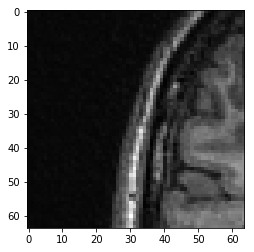

In [9]:
import scipy.misc
pred = predictionVol[60,:,:]
print (pred.shape)
imgplot = plt.imshow(pred, cmap='gray')
scipy.misc.imsave('pred.png', pred)

<h1> Load and Visualize LR Images

In [10]:
LRvol=valImgLR[10,:,:,:,:]
LRvol = np.squeeze(LRvol)
LRvol.shape


(64, 64, 64)

(64, 64)
0.912281679959668


d:\miniconda\envs\keraspy3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


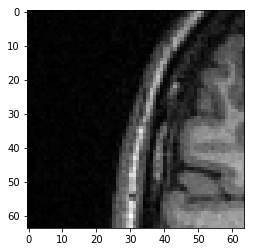

In [11]:
import scipy.misc
LR = LRvol[60,:,:]
print (LR.shape)
imgplot = plt.imshow(LR, cmap='gray')
scipy.misc.imsave('LR.png', LR)
print (np.max(LR))

<h1> Load and Visualize HR Images

In [12]:
valImgHR = np.load('patches3D/patchesStandardized/patchesvalImgHR.npy')

In [13]:
HRVol = valImgHR[10,:,:,:,:]
HRVol = np.squeeze(HRVol)
HRVol.shape



(64, 64, 64)

(64, 64)


d:\miniconda\envs\keraspy3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


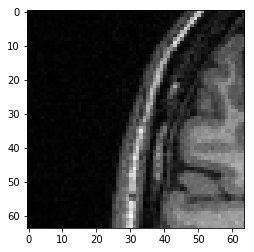

In [14]:
HR = HRVol[60,:,:]
print (HR.shape)
imgplot = plt.imshow(HR, cmap='gray')
scipy.misc.imsave('HR.png', HR)

<h1> Compute Metrics

In [27]:
def psnr_metric(y_true, y_pred):
    return psnr_metric_test(y_true, y_pred, max_val=1.0, name=None)
def psnr_metric_test(a, b, max_val, name=None):
   
    with ops.name_scope(name, 'PSNR', [a, b]):
   
        max_val = math_ops.cast(max_val, a.dtype)
        mse = math_ops.reduce_mean(math_ops.squared_difference(a, b), [-3, -2, -1])
        psnr_val = math_ops.subtract(
        20 * math_ops.log(max_val) / math_ops.log(10.0),
        np.float64(10 / np.log(10)) * math_ops.log(mse),
        name='psnr')
        return array_ops.identity(psnr_val)

In [42]:
LRvol=valImgLR[40,:,:,:,:]
# LRvol = np.squeeze(LRvol)
predictionVol = patchesPredicted[40,:,:,:,:]
# predictionVol = np.squeeze(predictionVol)
HRVol = valImgHR[40,:,:,:,:]
# HRVol = np.squeeze(HRVol)

LRvol32=  LRvol
LRvol32=LRvol32.astype('float32')
HRVol32 = HRVol
HRVol32=HRVol32.astype('float32')


In [37]:

psnrHRandLR = psnr_metric(HRVol32,LRvol32)
psnrHRandPred = psnr_metric(HRVol32, predictionVol)
psnrLRandPred = psnr_metric(LRvol32, predictionVol)


init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    print (sess.run(psnrHRandLR))
    print (sess.run(psnrHRandPred))
    print (sess.run(psnrLRandPred))

20.368904
35.47031
19.676334


In [43]:
def _tf_fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)


def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=11, sigma=1.5):
    window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
    K1 = 0.01
    K2 = 0.03
    L = 1  # depth of image (255 in case the image has a differnt scale)
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1],padding='VALID')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
    sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
    if cs_map:
        value = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2)),
                (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        value = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

In [49]:
ssim= tf_ssim(LRvol32, predictionVol)

In [50]:
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    print (sess.run(ssim))
  

0.7125363
